In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from glob import glob
from keras.preprocessing import image
from keras.layers import Dense, Flatten, Dropout, ELU, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from PIL import Image

import imageTrans as it

Using TensorFlow backend.


In [2]:
faceData = None
clmns = [ "xLeftEye", "yLeftEye", "xRightEye", "yRightEye",
          "xMouth",  "yMouth", "xLeftEar1", "yLeftEar1",
          "xLeftEar2", "yLeftEar2", "xLeftEar3", "yLeftEar3",
          "xRightEar1", "yRightEar1", "xRightEar2", "yRightEar2",
          "xRightEar3", "yRightEar3" ]

def readSavedFiles( path ):

    files = []

    with open( path, "r" ) as readFile:
        for line in readFile:
            files.append( line.strip() )

    return np.array( files )

def writeFilesList( path, files ):

    with open( path, "w") as outFile:
        for f in files:
            outFile.write( f + "\n" )

def readFaceData( catId ):
    """Reads the cat face data for the given id."""

    with open( "./pnts/" + catId + ".jpg.cat" ) as readFile:
        pnts = [ int(p) for p in readFile.read().split()[1:] ]

        return np.array( pnts )

def getImageId( fileName ):
    """Collect the image Ids from the files."""

    return re.split('\.|/', fileName )[3]

def rotate( vec, angle ):
    """Rotates the points in the vector."""

    res = np.zeros( shape = vec.shape )

    res[:,::2]  = (vec[:,::2] - 0.5) * np.cos(angle) - (vec[:,1::2] - 0.5) * np.sin(angle)
    res[:,1::2] = (vec[:,::2] - 0.5) * np.sin(angle) + (vec[:,1::2] - 0.5) * np.cos(angle)

    return res + 0.5

def readData( files ):
    """Generates a set of training data and its associated labels."""

    ids = []
    y = np.zeros( (len(files), 18) )

    i = 0

    for f in files:

        imgID = getImageId( f )
        ids.append( imgID )

        w, h = Image.open( f ).size
        pnts = readFaceData( imgID )

        y[i,::2]  = pnts[::2]/w
        y[i,1::2] = pnts[1::2]/h

        i += 1

    data = pd.DataFrame( { "id" : ids,
                           "xLeftEye"   : y[:,0],  "yLeftEye"   : y[:,1],
                           "xRightEye"  : y[:,2],  "yRightEye"  : y[:,3],
                           "xMouth"     : y[:,4],  "yMouth"     : y[:,5],
                           "xLeftEar1"  : y[:,6],  "yLeftEar1"  : y[:,7],
                           "xLeftEar2"  : y[:,8],  "yLeftEar2"  : y[:,9],
                           "xLeftEar3"  : y[:,10], "yLeftEar3"  : y[:,11],
                           "xRightEar1" : y[:,12], "yRightEar1" : y[:,13],
                           "xRightEar2" : y[:,14], "yRightEar2" : y[:,15],
                           "xRightEar3" : y[:,16], "yRightEar3" : y[:,17]} )

    data = data.set_index( "id" )

    return data

def genData( files, size = 256 ):
    """Generates a set of training data and its associated labels."""

    X = np.zeros( (len(files), size, size, 3) )
    i = 0

    ids = []

    for f in files:
        imgID = getImageId( f )
        ids.append( imgID )
        img = image.load_img( f, target_size = (size, size) )
        img = image.img_to_array(img)/255
        X[i] = img

        i += 1

    return X, faceData.loc[ ids ][ clmns ].values

def genBatch( files, batchSize, imgSize = 256, train = True ):
    """Generator of mini batches for training."""

    while (True):

        inds = np.random.permutation( len(files) )

        for start in range(0, len(files) - 1, batchSize):

            X, y = genData( files[ inds[start : start + batchSize] ], size = imgSize )

            if ( train ):
                #Mirror Flip:
                if ( np.random.rand() < 0.5 ):
                    X = it.mirrorImages( X, 0 )
                    y[:,::2] = 0.5 -(y[:,::2] - 0.5)

                #Brightness:
                #if ( np.random.rand() < 0.5 ):
                #    X = it.adjustBrightness( X, np.random.uniform(-0.2, 0.2) )

                #Scale:
                #if ( np.random.rand() < 0.1 ):
                #    scale = np.random.uniform( 2/3, 1.5 )
                #    X = it.scaleImages( X, scale )
                #    y = (y - 0.5) / scale + 0.5

                #Rotation:
                #if ( np.random.rand() < 0.1 ):
                #    theta = np.random.uniform( -np.pi/18, np.pi/18 )
                #    X = it.rotateImages( X, theta )
                #   y = rotate( y, -theta )

            yield X, y

def plotGrid( imgs, pnts, size = (10, 10), imgSize = 256 ):
    """Plots a grid of images. Assumes that len(data) is a perfect square."""

    m = int(np.sqrt( len(imgs)) )
    f, axarr = plt.subplots(m, m, figsize = size )

    k = 0

    for i in range(m):
        for j in range(m):

            axarr[i,j].imshow( imgs[k,:,:,:], vmin = 0, vmax = 1  )
            axarr[i,j].plot( pnts[k,::2]*imgSize, pnts[k,1::2]*imgSize, "bo" )
            axarr[i,j].get_xaxis().set_ticks([])
            axarr[i,j].get_yaxis().set_ticks([])

            k += 1

    f.tight_layout( pad = 0.5 )
    plt.show()

def plotLosses( losses ):
    """Plots training loss as a fucntion of epoch."""

    fig = plt.figure(1, figsize = (18,10))
    plt.plot( range(1, len(losses["loss"]) + 1), losses["loss"], "b-",
              linewidth = 3, label = "$\mathrm{training}$")
    plt.plot( range(1, len(losses["val_loss"]) + 1), losses["val_loss"], "g-",
              linewidth = 3, label = "$\mathrm{validation}$")
    plt.ylabel("$\mathrm{Loss}$")
    plt.xlabel("$\mathrm{Epoch}$")

    plt.yscale( "log" )
    plt.legend( loc = "best" )

    plt.show()

    return


In [3]:
def denseBlock( x, size, dropout ):
    """Createsn one dense layer unit."""

    dense      = Dense( size, use_bias = False, activation = "elu" )( x )
    bn         = ELU()( BatchNormalization()(dense) )
    dropout    = Dropout( dropout )( bn )

    return dropout

def genModel( imgSize = 256, dropout = 0.5 ):
    """Generates the VAE model."""

    pretrained = InceptionResNetV2( input_shape = (imgSize, imgSize, 3), weights = 'imagenet',
                                    include_top = False ) #, pooling = "avg" )
    inputLayer = pretrained.output

    flat = Flatten()( inputLayer )

    dense1 = denseBlock( flat,   1024, dropout )
    dense2 = denseBlock( dense1, 1024, dropout )
    dense3 = denseBlock( dense2, 1024, dropout )
    dense4 = denseBlock( dense3, 1024, dropout )
    dense5 = denseBlock( dense4, 1024, dropout )

    outputLayer = Dense( 18, activation = None )( dense5 )

    for layer in pretrained.layers:
        layer.trainable = False

    opt = Adam() #Adam( lr = 0.1, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1.0 )

    model = Model( inputs = pretrained.input, outputs = outputLayer )
    model.compile( optimizer = opt, loss = "mse" )

    return model


In [4]:
batchSize = 64
imgSize = 299
dropout = 0.0

model = genModel( imgSize, dropout )
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
trainFresh = False

catFiles = np.array( glob('./imgs/*.jpg') )
faceData = readData( catFiles )

if ( trainFresh ):

    valFrac = 0.1
    n = len(catFiles)

    inds = np.random.permutation( len(catFiles) )
    trainInds, valInds = inds[ : -int(n*valFrac) ], inds[ -int(n*valFrac) : ]

    train, val = catFiles[ trainInds ], catFiles[ valInds ]

    writeFilesList( "trainFiles.txt", train )
    writeFilesList( "valFiles.txt", val )

else:
    val   = readSavedFiles( "valFiles.txt" )
    train = readSavedFiles( "trainFiles.txt" )

In [6]:
#if ( not trainFresh ):
#    model.load_weights( "weights/catFaces.hdf5" )

earlyStopper1 = EarlyStopping( monitor='val_loss', patience = 100, verbose = 1 )
earlyStopper2 = EarlyStopping( monitor='loss', patience = 50 )
checkPointer = ModelCheckpoint( filepath = "weights/catFaces.hdf5", save_best_only = True, verbose = 1 )

losses = model.fit_generator( genBatch( train, batchSize, imgSize, False ),
                              steps_per_epoch = len(train) // batchSize,
                              validation_data = genBatch( val, batchSize, imgSize, False ),
                              validation_steps = len(val) // batchSize,
                              epochs = 5000, callbacks = [ earlyStopper1, earlyStopper2, checkPointer ] )

Epoch 1/5000
139/140 [============================>.] - ETA: 0s - loss: 0.1657
Epoch 00001: val_loss improved from inf to 0.05254, saving model to weights/catFaces.hdf5
140/140 [==============================] - 182s 1s/step - loss: 0.1646 - val_loss: 0.0525
Epoch 2/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0208
Epoch 00002: val_loss improved from 0.05254 to 0.04953, saving model to weights/catFaces.hdf5
140/140 [==============================] - 132s 941ms/step - loss: 0.0208 - val_loss: 0.0495
Epoch 3/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0160
Epoch 00003: val_loss improved from 0.04953 to 0.02586, saving model to weights/catFaces.hdf5
140/140 [==============================] - 131s 934ms/step - loss: 0.0160 - val_loss: 0.0259
Epoch 4/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0138
Epoch 00004: val_loss improved from 0.02586 to 0.02297, saving model to weights/catFaces.hdf5
140/140 [===========================

139/140 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 00035: val_loss did not improve
140/140 [==============================] - 127s 908ms/step - loss: 0.0032 - val_loss: 0.0079
Epoch 36/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 00036: val_loss did not improve
140/140 [==============================] - 130s 927ms/step - loss: 0.0031 - val_loss: 0.0089
Epoch 37/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 00037: val_loss did not improve
140/140 [==============================] - 127s 909ms/step - loss: 0.0032 - val_loss: 0.0081
Epoch 38/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00038: val_loss improved from 0.00736 to 0.00715, saving model to weights/catFaces.hdf5
140/140 [==============================] - 130s 932ms/step - loss: 0.0028 - val_loss: 0.0072
Epoch 39/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00039: val_loss did not impr

139/140 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00072: val_loss did not improve
140/140 [==============================] - 125s 896ms/step - loss: 0.0021 - val_loss: 0.0070
Epoch 73/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00073: val_loss improved from 0.00610 to 0.00610, saving model to weights/catFaces.hdf5
140/140 [==============================] - 130s 927ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 74/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00074: val_loss did not improve
140/140 [==============================] - 127s 904ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 75/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00075: val_loss did not improve
140/140 [==============================] - 126s 899ms/step - loss: 0.0021 - val_loss: 0.0071
Epoch 76/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00076: val_loss did not impr

139/140 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00109: val_loss did not improve
140/140 [==============================] - 127s 908ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 110/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00110: val_loss did not improve
140/140 [==============================] - 126s 902ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 111/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00111: val_loss did not improve
140/140 [==============================] - 126s 903ms/step - loss: 0.0016 - val_loss: 0.0060
Epoch 112/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00112: val_loss did not improve
140/140 [==============================] - 125s 894ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 113/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00113: val_loss did not improve
140/140 [==============================] - 127s 

139/140 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00147: val_loss did not improve
140/140 [==============================] - 127s 907ms/step - loss: 0.0013 - val_loss: 0.0055
Epoch 148/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00148: val_loss did not improve
140/140 [==============================] - 127s 904ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 149/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00149: val_loss did not improve
140/140 [==============================] - 127s 906ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 150/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00150: val_loss did not improve
140/140 [==============================] - 127s 905ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 151/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00151: val_loss did not improve
140/140 [==============================] - 127s 

Epoch 185/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00185: val_loss did not improve
140/140 [==============================] - 127s 906ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 186/5000
139/140 [============================>.] - ETA: 0s - loss: 9.9072e-04
Epoch 00186: val_loss did not improve
140/140 [==============================] - 125s 894ms/step - loss: 9.9518e-04 - val_loss: 0.0049
Epoch 187/5000
139/140 [============================>.] - ETA: 0s - loss: 9.4179e-04
Epoch 00187: val_loss did not improve
140/140 [==============================] - 125s 895ms/step - loss: 9.3974e-04 - val_loss: 0.0057
Epoch 188/5000
139/140 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00188: val_loss improved from 0.00489 to 0.00422, saving model to weights/catFaces.hdf5
140/140 [==============================] - 131s 933ms/step - loss: 0.0010 - val_loss: 0.0042
Epoch 189/5000
139/140 [============================>.] - ETA: 0s - loss: 9.9032

139/140 [============================>.] - ETA: 0s - loss: 8.8836e-04
Epoch 00222: val_loss did not improve
140/140 [==============================] - 125s 892ms/step - loss: 8.8643e-04 - val_loss: 0.0051
Epoch 223/5000
139/140 [============================>.] - ETA: 0s - loss: 8.0012e-04
Epoch 00223: val_loss did not improve
140/140 [==============================] - 127s 905ms/step - loss: 7.9770e-04 - val_loss: 0.0048
Epoch 224/5000
139/140 [============================>.] - ETA: 0s - loss: 8.3491e-04
Epoch 00224: val_loss did not improve
140/140 [==============================] - 125s 894ms/step - loss: 8.3851e-04 - val_loss: 0.0049
Epoch 225/5000
139/140 [============================>.] - ETA: 0s - loss: 7.6387e-04
Epoch 00225: val_loss did not improve
140/140 [==============================] - 126s 902ms/step - loss: 7.6404e-04 - val_loss: 0.0046
Epoch 226/5000
139/140 [============================>.] - ETA: 0s - loss: 7.9621e-04
Epoch 00226: val_loss did not improve
140/140 [===

139/140 [============================>.] - ETA: 0s - loss: 7.6043e-04
Epoch 00259: val_loss did not improve
140/140 [==============================] - 127s 907ms/step - loss: 7.5923e-04 - val_loss: 0.0047
Epoch 260/5000
139/140 [============================>.] - ETA: 0s - loss: 7.7616e-04
Epoch 00260: val_loss did not improve
140/140 [==============================] - 126s 900ms/step - loss: 7.7707e-04 - val_loss: 0.0058
Epoch 261/5000
139/140 [============================>.] - ETA: 0s - loss: 7.2741e-04
Epoch 00261: val_loss did not improve
140/140 [==============================] - 126s 902ms/step - loss: 7.2640e-04 - val_loss: 0.0051
Epoch 262/5000
139/140 [============================>.] - ETA: 0s - loss: 6.7420e-04
Epoch 00262: val_loss did not improve
140/140 [==============================] - 127s 906ms/step - loss: 6.7356e-04 - val_loss: 0.0049
Epoch 263/5000
139/140 [============================>.] - ETA: 0s - loss: 7.8316e-04
Epoch 00263: val_loss did not improve
140/140 [===

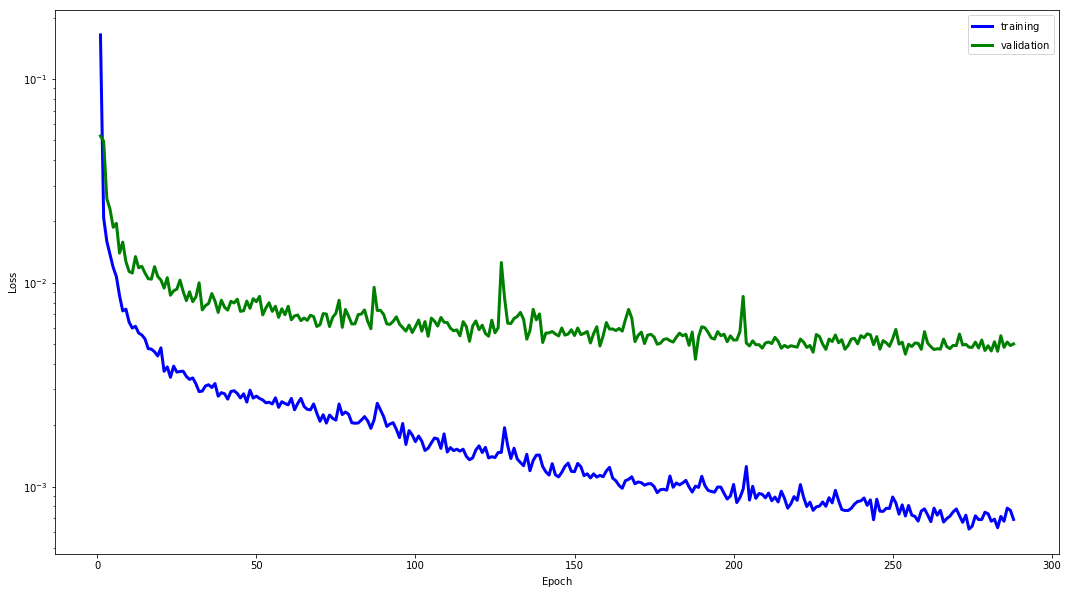

In [7]:
model.save_weights( "weights/catFaces_last.hdf5" )
plotLosses( losses.history )


		Data:


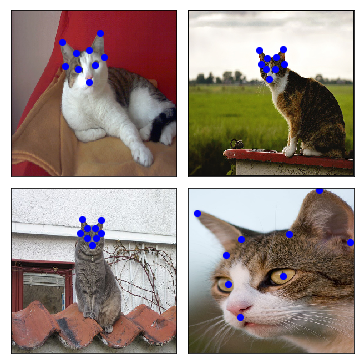


		Predicted:


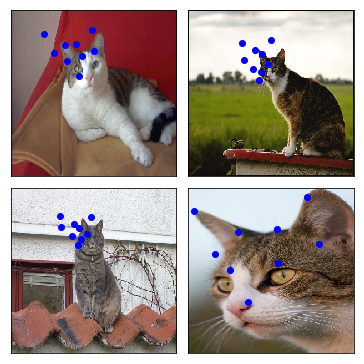

In [12]:
model.load_weights( "weights/catFaces.hdf5" )

catSample, y = next( genBatch( train, 4, imgSize, False ) )

ypred = model.predict( catSample )

print( "\n\t\tData:" )
plotGrid( catSample, y, size = (5, 5), imgSize = imgSize )

print( "\n\t\tPredicted:" )
plotGrid( catSample, ypred, size = (5, 5) )